# Fake Review Detection

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sqlite3
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Load Data

In [9]:
conn = sqlite3.connect('../data/yelpResData.db')
conn.text_factory = lambda b: b.decode(errors = 'ignore')

In [10]:
# check table names in the database
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

review
restaurant
reviewer


#### Load restaurant dataset

In [11]:
# load restaurant table to df
res = pd.read_sql("select * from restaurant;", conn)
res.columns

Index(['restaurantID', 'name', 'location', 'reviewCount', 'rating',
       'categories', 'address', 'Hours', 'GoodforKids', 'AcceptsCreditCards',
       'Parking', 'Attire', 'GoodforGroups', 'PriceRange', 'TakesReservations',
       'Delivery', 'Takeout', 'WaiterService', 'OutdoorSeating', 'WiFi',
       'GoodFor', 'Alcohol', 'NoiseLevel', 'Ambience', 'HasTV', 'Caters',
       'WheelchairAccessible', 'webSite', 'phoneNumber', 'filReviewCount'],
      dtype='object')

In [12]:
# take selection columns
columns = ['restaurantID', 'name', 'rating']
res = res[columns]

#### Load review dataset

In [13]:
# load review table to df
review = pd.read_sql("select * from review;", conn)
review.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'rating',
       'usefulCount', 'coolCount', 'funnyCount', 'flagged', 'restaurantID'],
      dtype='object')

In [14]:
# check the classes in flagged column
review.flagged.value_counts()

NR    402774
YR    318678
N      58716
Y       8303
Name: flagged, dtype: int64

There are 4 classes in the review dataframe. Y and N classes are not filtered by the Yelp fake review detection engine, less reliable labelling. Since we have about 700k reviews left (large enough) and the N and Y classes combined makes only 8.5% of the data, we decided to remove them, only keeping NR and YR classes.
- NR: True review
- YR: Fake review

In [15]:
review = review[(review.flagged != 'Y') & (review.flagged != 'N')]
review.reset_index(drop=True,inplace=True)

In [16]:
# checking if there are duplicated reviews
if (review.shape[0] == review.reviewID.nunique()):
    print('there are no duplicated reviews')
else:
    print('Duplicated reviews are')
    mask = review.duplicated(subset='reviewID', keep = False)
    review[mask]

there are no duplicated reviews


In [17]:
# clean the date column in review
mask = review.date.str.contains('Update')
ok_date = review[~mask]
notok_date = review[mask]
notok_date['date'] = notok_date['date'].apply(lambda x: str(x).split()[2])
review = pd.concat([ok_date, notok_date])

In [18]:
# convert date to datetime
review.date = pd.to_datetime(review.date)

#### Load reviewer dataset

In [19]:
# load reviewer table to df
reviewer = pd.read_sql("select * from reviewer;", conn)
reviewer.columns

Index(['reviewerID', 'name', 'location', 'yelpJoinDate', 'friendCount',
       'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount',
       'complimentCount', 'tipCount', 'fanCount'],
      dtype='object')

In [20]:
# repeated columns in review and reviewer
review_reviewer_intersect = set(review.columns).intersection(set(reviewer.columns))
review_res_intersect = set(review.columns).intersection(set(res.columns))

print('review_reviewer_intersect: {}'.format(review_reviewer_intersect))
print('review_res_intersect: {}'.format(review_res_intersect))

review_reviewer_intersect: {'coolCount', 'reviewerID', 'usefulCount', 'funnyCount'}
review_res_intersect: {'rating', 'restaurantID'}


Both review and reviewer df have columns coolCount, funnyCount, usefulCount. We need to differentiate them. Similarly, review and restaurant both have rating columns

In [21]:
review = review.rename(columns={'coolCount':'review_coolCount', 'funnyCount':'review_funnyCount', 
                                'usefulCount':'review_usefulCount', 'rating': 'review_rating'})

In [22]:
# the yelpJoinDate is in format 'June 2019', change it to datetime object
reviewer['yelpJoinDate'] = reviewer['yelpJoinDate'].apply(lambda x: datetime.strftime(datetime.strptime(x, '%B %Y'), '01/%m/%Y'))
reviewer['yelpJoinDate'] = pd.to_datetime(reviewer['yelpJoinDate'])
reviewer['yelpJoinDate'].values[0]

numpy.datetime64('2009-01-10T00:00:00.000000000')

In [23]:
# merge the 3 tables
df_merged = review.merge(reviewer, on='reviewerID', how='inner')
df = df_merged.merge(res, on='restaurantID', how='inner')
print('Final df columns:')
print(df.columns.to_list())
df.head()

Final df columns:
['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating', 'review_usefulCount', 'review_coolCount', 'review_funnyCount', 'flagged', 'restaurantID', 'name_x', 'location', 'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount', 'fanCount', 'name_y', 'rating']


,date,reviewID,reviewerID,reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,restaurantID,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,name_y,rating
0,2012-09-25,xvdJntJlo01tHu83-vXiRw,bNYesZ944s6IJVowOnB0iA,Good choice by our Chicago friends for our fin...,4,0,0,0,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,48,5,41,5,5,2,0,1,Slurping Turtle,3.5
1,2012-06-23,Z4oAUd6mIOhxxDsle3trPA,BSh3h1J4mdSmEsb8FFdf0Q,"I'm not a Takashi fan, so I was a bit hesitant...",4,0,0,0,YR,KU_Ze0TpR2HgKG2OpTh2NA,...,116,2,93,16,19,10,0,2,Slurping Turtle,3.5
2,2012-10-10,71c7BDude0l5tNjtxRZzMg,XVvbDeYn5Dk-MteNHwjC7Q,I should have read the the 3 stars and below r...,2,0,0,0,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,14,1,5,1,3,0,4,1,Slurping Turtle,3.5
3,2011-12-15,Vrzm2xmm2aBqBRqs3yK9Zw,om5ZiponkpRqUNa3pVPiRg,It must be called slurping turtle because thei...,3,8,3,4,YR,KU_Ze0TpR2HgKG2OpTh2NA,...,2063,347,12660,9617,6682,6948,605,503,Slurping Turtle,3.5
4,2012-09-07,coKi6jCbVd4qSUpoE5_0iA,LZt80LbsfQ9kOz96H7c1bA,I'm surprised this place is getting so many ne...,4,2,2,1,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,132,0,154,84,22,24,3,7,Slurping Turtle,3.5


In [24]:
# easy loading next time
# df.to_pickle('../data/merged_df.pkl')
df = pd.read_pickle('../data/merged_df.pkl')

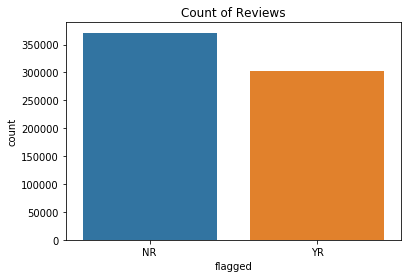

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='flagged', data=df)
plt.title("Count of Reviews")
plt.show()

In [1]:
print("hello")

hello
